<a href="https://colab.research.google.com/github/Utkarshp1/Spoiler-Detection-in-Movie-Review/blob/master/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [ ]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle
#Check the present working directory using pwd command

/content/gdrive/My Drive/Kaggle


In [ ]:
os.getcwd()

'/content/gdrive/My Drive/Kaggle'

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from nltk.stem import WordNetLemmatizer
import pickle
import pandas as pd
import time
import numpy as np
import re
import spacy
import nltk

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.model_selection import ShuffleSplit

In [ ]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
from nltk.stem import PorterStemmer

In [ ]:
df = pd.read_json("IMDB_reviews.json", lines=True)
df.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"


   log-Reg
-----------------
* with stopwords
* without stopwords
* with bigram without stopwords
* with bigram with frequency
* Bigram + Stemming + words <=10 reviews (remove)

SVM
----
* Normal Model Without any restrictions (Linear Kernel)
* Bigram + Linear Kernel
* Bigram + words <=10 reviews (remove) + Linear Kernel
* Bigram + words <=10 reviews (remove) + Polynomial Kernel (degree 2)
* Bigram + Stemming + words <=10 reviews (remove) + Linear Kernel
* linear kernel without stopwords
* linear kernel with bigram with frequency


 
----

# Data Preparation

## Subsampling

In [ ]:
def get_part_data(df, num_reviews):
  num_pos_reviews = df['is_spoiler'].sum()   # Number of spoilers in the dataset
  fraction_pos = num_reviews/num_pos_reviews  # fraction of spoiler reviews to be returned
  fraction_neg = num_reviews/(df.shape[0] - num_pos_reviews)  # fraction of non-spoiler reviews to be returned 

  df_pos = df[df['is_spoiler']]['review_text'].sample(frac = fraction_pos, random_state = 2)
  df_neg = df[df['is_spoiler'] == False]['review_text'].sample(frac = fraction_neg, random_state = 2)

  df_reviews = pd.concat([df_pos, df_neg])
  df_reviews = df_reviews.reset_index(drop=True)
  labels = [1]*(num_reviews*2)
  print(len(labels))
  labels[num_reviews:] = [0]*num_reviews

  return df_reviews, labels

In [ ]:
df_reviews, labels = get_part_data(df, 5000)

10000


## Test Train Split (90% train, 10% test)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_reviews, labels, test_size=0.1, random_state=21, stratify=labels)

In [ ]:
X_train.shape, X_test.shape, len(y_train), len(y_test)

((9000,), (1000,), 9000, 1000)

## Bag of Words

In [ ]:
def get_feature_vector(X, min_df=0, stop_words=False, ngram_range=(1,1), verbose = True, tokenizer=None, binary=False):
  vect = CountVectorizer(min_df=min_df, stop_words = "english" if stop_words else None, ngram_range=ngram_range, tokenizer=tokenizer, binary=binary)
  vect.fit(X)                                             # Create the vocabulary of words for the given reviews dataset

  print("Vocabulary size: {}".format(len(vect.vocabulary_)))

  if verbose:
    feature_names = vect.get_feature_names()
    print("Number of features: {}".format(len(feature_names)))
    print("First 20 features:\n{}".format(feature_names[:20]))
    print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
    print("Every 2000th feature:\n{}".format(feature_names[::2000]))

  bag_of_words = vect.transform(X)               # Transform the reviews into feature vector
  bag_of_words_norm = normalize(bag_of_words, norm='l2')  # Normalize the feature vectors obtained

  return bag_of_words_norm, vect

# Model

In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    print("Training accuracy: " + str(model.score(X_train, y_train)))
    print("Testing accuracy: " + str(model.score(X_test, y_test)))
    y_pred = model.predict(X_test)
    print("Precision on test data: " + str(precision_score(y_test, y_pred)))
    print("Recall on test data: " + str(recall_score(y_test, y_pred)))
    print("f1 score on test data: " + str(f1_score(y_test, y_pred)))

In [ ]:
def tune_parameters(model, X_train, y_train, param_grid, verbose=False, cv=5):
    clf = GridSearchCV(model, param_grid=param_grid, cv=cv, n_jobs=-1, return_train_score=True)
    clf.fit(X_train, y_train)
    results = clf.cv_results_

    if verbose:
        plt.figure()
        plt.plot(results['param_C'], results['mean_train_score'])
        plt.plot(results['param_C'], results['mean_test_score'])
        plt.xlabel(list(param_grid.keys())[0])
        plt.ylabel("Accuracy")
        plt.show()

    return clf

In [ ]:
ss = ShuffleSplit(n_splits=1, test_size=0.20, random_state=0)

## 1. With Stopwords

In [ ]:
bag_of_words_norm, vect = get_feature_vector(X_train)

Vocabulary size: 48672
Number of features: 48672
First 20 features:
['00', '000', '0000000', '0001', '000usd', '007', '00s', '00t', '01', '01100011', '01101100', '01110101', '01111001', '02', '03', '04', '045', '05', '06', '07']
Features 20010 to 20030:
['heiglit', 'heil', 'heinlei', 'heinlein', 'heinous', 'heinously', 'heinreich', 'heinrich', 'heinrichs', 'heir', 'heiress', 'heirloom', 'heirs', 'heisserer', 'heist', 'heists', 'hejira', 'hela', 'helander', 'held']
Every 2000th feature:
['00', 'als', 'barbarity', 'brin', 'chuck', 'cowardice', 'didlaugh', 'elena', 'fedora', 'gerd', 'heidelberg', 'infinity', 'kimball', 'm203', 'mlk', 'obstructions', 'persona', 'psychopaths', 'resputin', 'scupper', 'socialists', 'superimposed', 'torso', 'using', 'woolsey']


In [ ]:
bag_of_words_test = vect.transform(X_test)
bag_of_words_test_norm = normalize(bag_of_words_test, norm='l2')
bag_of_words_test_norm

<1000x48672 sparse matrix of type '<class 'numpy.float64'>'
	with 153846 stored elements in Compressed Sparse Row format>

### 1.1 Logistic Regression

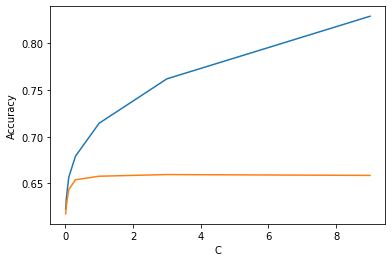

In [ ]:
parameters = {'C': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 9.0]}
log_reg = LogisticRegression(max_iter=1000)
grid_search = tune_parameters(log_reg, bag_of_words_norm, y_train, parameters, verbose=True)  

In [ ]:
log_reg_best = grid_search.best_estimator_
evaluate_model(log_reg_best, bag_of_words_norm, bag_of_words_test_norm, y_train, y_test)

Training accuracy: 0.7575555555555555
Testing accuracy: 0.664
Precision on test data: 0.6633466135458167
Recall on test data: 0.666
f1 score on test data: 0.6646706586826348


### 1.2 SVM with Linear Kernel

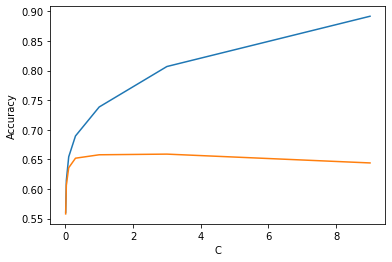

In [ ]:
parameters = {'C': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 9.0]}
svm = LinearSVC(C=10, loss='hinge', max_iter=10000)
grid_search = tune_parameters(svm, bag_of_words_norm, y_train, parameters, verbose=True)

In [ ]:
svm_best = grid_search.best_estimator_
evaluate_model(svm_best, bag_of_words_norm, bag_of_words_test_norm, y_train, y_test)

Training accuracy: 0.8011111111111111
Testing accuracy: 0.668
Precision on test data: 0.668
Recall on test data: 0.668
f1 score on test data: 0.668


### 1.3 SVM with Polynomial Kernel (Degree 2) 

In [ ]:
parameters = {'C': [0.01, 0.1, 1.0], 'coef0' : [1, 5, 10]}
svm = SVC(kernel='poly', degree=2)
grid_search = tune_parameters(svm, bag_of_words_norm, y_train, parameters, cv=ss)

In [ ]:
svm_best = grid_search.best_estimator_
evaluate_model(svm_best, bag_of_words_norm, bag_of_words_test_norm, y_train, y_test)

Training accuracy: 0.698
Testing accuracy: 0.669
Precision on test data: 0.6666666666666666
Recall on test data: 0.676
f1 score on test data: 0.6713008937437934


In [ ]:
results = pd.DataFrame(grid_search.cv_results_)
results.head()

In [ ]:
grid_search.best_params_

{'C': 0.1, 'coef0': 1}

In [ ]:
filename = '1.3_GridSearchCV.sav'
pickle.dump(grid_search, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
results = pd.DataFrame(loaded_model.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_coef0,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,119.054476,0.0,28.311503,0.0,0.01,1,"{'C': 0.01, 'coef0': 1}",0.618889,0.618889,0.0,9,0.625139,0.625139,0.0
1,113.002061,0.0,26.749519,0.0,0.01,5,"{'C': 0.01, 'coef0': 5}",0.648333,0.648333,0.0,6,0.657917,0.657917,0.0
2,113.054517,0.0,25.889260,0.0,0.01,10,"{'C': 0.01, 'coef0': 10}",0.655556,0.655556,0.0,3,0.678889,0.678889,0.0
3,109.058439,0.0,25.420046,0.0,0.1,1,"{'C': 0.1, 'coef0': 1}",0.657778,0.657778,0.0,1,0.699722,0.699722,0.0
4,106.097372,0.0,24.908029,0.0,0.1,5,"{'C': 0.1, 'coef0': 5}",0.655000,0.655000,0.0,4,0.750972,0.750972,0.0


### 1.4 SVM with Gaussian Kernel

In [ ]:
parameters = {'C': [0.01, 0.1, 1.0, 10], 'gamma' : [1, 5, 10]}
svm = SVC(kernel="rbf")
grid_search = tune_parameters(svm, bag_of_words_norm, y_train, parameters, cv=ss)

In [ ]:
svm_best = grid_search.best_estimator_
evaluate_model(svm_best, bag_of_words_norm, bag_of_words_test_norm, y_train, y_test)

Training accuracy: 0.8108888888888889
Testing accuracy: 0.674
Precision on test data: 0.6827731092436975
Recall on test data: 0.65
f1 score on test data: 0.665983606557377


In [ ]:
results = pd.DataFrame(grid_search.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,126.617624,0.0,31.890661,0.0,0.01,1,"{'C': 0.01, 'gamma': 1}",0.602778,0.602778,0.0,9,0.599861,0.599861,0.0
1,126.245202,0.0,31.850865,0.0,0.01,5,"{'C': 0.01, 'gamma': 5}",0.491667,0.491667,0.0,11,0.502083,0.502083,0.0
2,126.541163,0.0,31.970873,0.0,0.01,10,"{'C': 0.01, 'gamma': 10}",0.491667,0.491667,0.0,11,0.502083,0.502083,0.0
3,117.045768,0.0,27.894872,0.0,0.1,1,"{'C': 0.1, 'gamma': 1}",0.642778,0.642778,0.0,3,0.661389,0.661389,0.0
4,124.802529,0.0,29.772929,0.0,0.1,5,"{'C': 0.1, 'gamma': 5}",0.614444,0.614444,0.0,8,0.638194,0.638194,0.0


In [ ]:
grid_search.best_params_

{'C': 1.0, 'gamma': 1}

In [ ]:
filename = '1.4_GridSearchCV.sav'
pickle.dump(grid_search, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
results = pd.DataFrame(loaded_model.cv_results_)
results.head()

### kNN (k-Nearest Neighbours n=5)

In [ ]:
knn_1 = KNeighborsClassifier(n_neighbors=5)
knn_1.fit(bag_of_words_norm, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
knn_1.score(bag_of_words_norm, y_train)

0.6793333333333333

In [ ]:
knn_1.score(bag_of_words_test_norm, y_test)

0.533

### Observations
* Accuracy of the model increased as we increased the complexity of model from SVM linear kernel to SVM Gaussian Kernel.
* Irrelevant features created due to repetition of words such as 'heir', 'heiress', 'heirs'.

## 2. Without Stopwords

In [ ]:
bag_of_words_norm, vect = get_feature_vector(X_train, stop_words=True)

Vocabulary size: 48362
Number of features: 48362
First 20 features:
['00', '000', '0000000', '0001', '000usd', '007', '00s', '00t', '01', '01100011', '01101100', '01110101', '01111001', '02', '03', '04', '045', '05', '06', '07']
Features 20010 to 20030:
['henry', 'hens', 'hensleigh', 'hensley', 'henson', 'hensons', 'henstridge', 'hepbern', 'hepburn', 'heptopods', 'heracles', 'herald', 'heralded', 'heralding', 'heralds', 'herb', 'herbert', 'herbie', 'herbivores', 'herc']
Every 2000th feature:
['00', 'altercations', 'bargains', 'brock', 'cinders', 'crammed', 'digiamio', 'eloise', 'fergus', 'gigantic', 'henke', 'ink', 'knew', 'mage', 'mona', 'ojai', 'philosophical', 'pursing', 'revise', 'sellable', 'sorta', 'svelte', 'translation', 'venomous', 'yanks']


In [ ]:
bag_of_words_test = vect.transform(X_test)
bag_of_words_test_norm = normalize(bag_of_words_test, norm='l2')
bag_of_words_test_norm

<1000x48362 sparse matrix of type '<class 'numpy.float64'>'
	with 100187 stored elements in Compressed Sparse Row format>

### 2.1 Logistic Regression

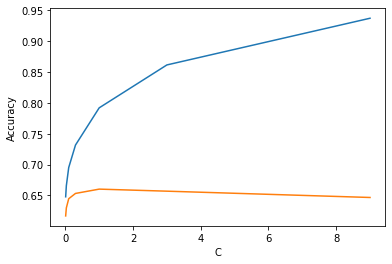

In [ ]:
parameters = {'C': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 9.0]}
log_reg = LogisticRegression(max_iter=1000)         # Creating an instance of Scikit Learn LogisticRegression class
grid_search = tune_parameters(log_reg, bag_of_words_norm, y_train, parameters, verbose=True)  

In [ ]:
log_reg_best = grid_search.best_estimator_
evaluate_model(log_reg_best, bag_of_words_norm, bag_of_words_test_norm, y_train, y_test)

Training accuracy: 0.7816666666666666
Testing accuracy: 0.656
Precision on test data: 0.6631799163179917
Recall on test data: 0.634
f1 score on test data: 0.6482617586912066


### 2.2 SVM with Linear Kernel

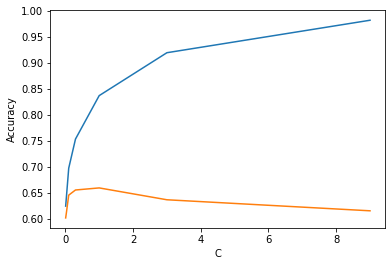

In [ ]:
parameters = {'C': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 9.0]}
svm = LinearSVC(C=10, loss='hinge', max_iter=10000)
grid_search = tune_parameters(svm, bag_of_words_norm, y_train, parameters, verbose=True)

In [ ]:
svm_best = grid_search.best_estimator_
evaluate_model(svm_best, bag_of_words_norm, bag_of_words_test_norm, y_train, y_test)

Training accuracy: 0.8266666666666667
Testing accuracy: 0.654
Precision on test data: 0.668859649122807
Recall on test data: 0.61
f1 score on test data: 0.6380753138075314


### 2.3 SVM with Polynomial Kernel (degree 2)

In [ ]:
parameters = {'C': [0.01, 0.1, 1.0], 'coef0' : [1, 5, 10]}
svm = SVC(kernel='poly', degree=2)
grid_search = tune_parameters(svm, bag_of_words_norm, y_train, parameters, cv=ss)

In [ ]:
svm_best = grid_search.best_estimator_
evaluate_model(svm_best, bag_of_words_norm, bag_of_words_test_norm, y_train, y_test)

Training accuracy: 0.7733333333333333
Testing accuracy: 0.663
Precision on test data: 0.6775599128540305
Recall on test data: 0.622
f1 score on test data: 0.64859228362878


In [ ]:
results = pd.DataFrame(grid_search.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_coef0,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,81.619480,0.0,20.286001,0.0,0.01,1,"{'C': 0.01, 'coef0': 1}",0.563333,0.563333,0.0,9,0.593194,0.593194,0.0
1,77.557007,0.0,18.923199,0.0,0.01,5,"{'C': 0.01, 'coef0': 5}",0.650000,0.650000,0.0,5,0.703333,0.703333,0.0
2,76.645928,0.0,18.180186,0.0,0.01,10,"{'C': 0.01, 'coef0': 10}",0.660556,0.660556,0.0,2,0.734167,0.734167,0.0
3,76.576484,0.0,18.223875,0.0,0.1,1,"{'C': 0.1, 'coef0': 1}",0.662778,0.662778,0.0,1,0.778333,0.778333,0.0
4,71.963917,0.0,16.961619,0.0,0.1,5,"{'C': 0.1, 'coef0': 5}",0.653889,0.653889,0.0,3,0.865278,0.865278,0.0


In [ ]:
grid_search.best_params_

{'C': 0.1, 'coef0': 1}

In [ ]:
filename = '2.3_GridSearchCV.sav'
pickle.dump(grid_search, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
results = pd.DataFrame(loaded_model.cv_results_)
results.head()

### 2.4 SVM with Gaussian Kernel

In [ ]:
parameters = {'C': [0.01, 0.1, 1.0, 10], 'gamma' : [1, 3, 10]}
svm = SVC(kernel="rbf")
grid_search = tune_parameters(svm, bag_of_words_norm, y_train, parameters, cv=ss)

In [ ]:
grid_search.best_params_

{'C': 1.0, 'gamma': 1}

In [ ]:
svm_best = grid_search.best_estimator_
evaluate_model(svm_best, bag_of_words_norm, bag_of_words_test_norm, y_train, y_test)

Training accuracy: 0.9537777777777777
Testing accuracy: 0.671
Precision on test data: 0.6815286624203821
Recall on test data: 0.642
f1 score on test data: 0.6611740473738414


In [ ]:
results = pd.DataFrame(grid_search.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,84.253220,0.0,20.847738,0.0,0.01,1,"{'C': 0.01, 'gamma': 1}",0.491667,0.491667,0.0,8,0.502083,0.502083,0.0
1,83.991072,0.0,21.029014,0.0,0.01,3,"{'C': 0.01, 'gamma': 3}",0.491667,0.491667,0.0,8,0.502083,0.502083,0.0
2,86.988489,0.0,21.052115,0.0,0.01,10,"{'C': 0.01, 'gamma': 10}",0.491667,0.491667,0.0,8,0.502083,0.502083,0.0
3,85.232176,0.0,20.662672,0.0,0.1,1,"{'C': 0.1, 'gamma': 1}",0.592778,0.592778,0.0,5,0.672500,0.672500,0.0
4,85.262628,0.0,21.003951,0.0,0.1,3,"{'C': 0.1, 'gamma': 3}",0.491667,0.491667,0.0,8,0.502222,0.502222,0.0


In [ ]:
filename = '2.4_GridSearchCV.sav'
pickle.dump(grid_search, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
results = pd.DataFrame(loaded_model.cv_results_)
results.head()

### Observations
* The accuracy of the model reduced when we removed stopwords. This maybe because some stopwords maybe relevant in detecting spoilers.
* Accuracy of the model increased as we increased the complexity of model from SVM linear kernel to SVM Gaussian Kernel.
* Irrelevant features created due to repetition of words such as 'herald', 'heralds', 'heralding', 'heralded'.

## 3. With Bigrams, with stopwords, words that appear in <=5 documents removed

In [ ]:
bag_of_words_norm, vect = get_feature_vector(X_train, ngram_range=(1,2), min_df=5)

Vocabulary size: 78398
Number of features: 78398
First 20 features:
['00', '000', '000 000', '000 and', '000 year', '007', '02', '05', '07', '09', '10', '10 000', '10 10', '10 15', '10 all', '10 also', '10 and', '10 as', '10 at', '10 because']
Features 20010 to 20030:
['embassy', 'embedded', 'embellished', 'emblem', 'embodied', 'embodies', 'embodies the', 'embodiment', 'embodiment of', 'embrace', 'embrace the', 'embraced', 'embraces', 'embracing', 'embryos', 'emerge', 'emerge and', 'emerge from', 'emerged', 'emerged as']
Every 2000th feature:
['00', 'aliens are', 'and excellent', 'apparently the', 'backstory and', 'bigelow', 'by stephen', 'classic like', 'cringe worthy', 'director could', 'embark', 'fabric', 'five', 'get worse', 'hans zimmer', 'him anyway', 'importantly', 'is executed', 'job was', 'leper', 'male characters', 'monumental', 'nelson and', 'of gold', 'opinion is', 'perhaps just', 'protocol', 'reported', 'scope', 'simply enjoy', 'stark', 'takes up', 'the continuity', 'the s

In [ ]:
bag_of_words_test = vect.transform(X_test)
bag_of_words_test_norm = normalize(bag_of_words_test, norm='l2')
bag_of_words_test_norm

<1000x78398 sparse matrix of type '<class 'numpy.float64'>'
	with 297743 stored elements in Compressed Sparse Row format>

### 3.1 Logistic Regression

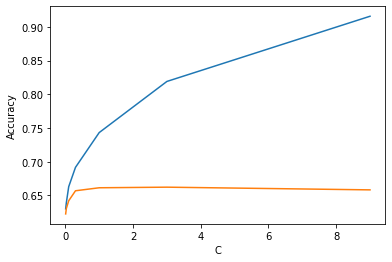

In [ ]:
parameters = {'C': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 9.0]}
log_reg = LogisticRegression(max_iter=1000)         # Creating an instance of Scikit Learn LogisticRegression class
grid_search = tune_parameters(log_reg, bag_of_words_norm, y_train, parameters, verbose=True)

In [ ]:
log_reg_best = grid_search.best_estimator_
evaluate_model(log_reg_best, bag_of_words_norm, bag_of_words_test_norm, y_train, y_test)

Training accuracy: 0.8151111111111111
Testing accuracy: 0.667
Precision on test data: 0.6750524109014675
Recall on test data: 0.644
f1 score on test data: 0.6591606960081883


### 3.2 SVM with Linear Kernel

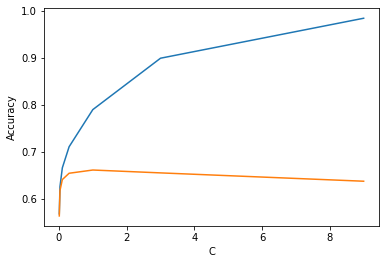

In [ ]:
parameters = {'C': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 9.0]}
svm = LinearSVC(C=10, loss='hinge', max_iter=10000)
grid_search = tune_parameters(svm, bag_of_words_norm, y_train, parameters, verbose=True)

In [ ]:
grid_search.best_params_

{'C': 1.0}

In [ ]:
svm_best = grid_search.best_estimator_
evaluate_model(svm_best, bag_of_words_norm, bag_of_words_test_norm, y_train, y_test)

Training accuracy: 0.7848888888888889
Testing accuracy: 0.691
Precision on test data: 0.6906187624750499
Recall on test data: 0.692
f1 score on test data: 0.6913086913086913


### 3.3 SVM with Polynomial Kernel (degree=2)

In [ ]:
parameters = {'C': [0.01, 0.1, 1.0], 'coef0' : [1, 3, 10]}
svm = SVC(kernel='poly', degree=2)
grid_search = tune_parameters(svm, bag_of_words_norm, y_train, parameters, cv=ss)

In [ ]:
svm_best = grid_search.best_estimator_
evaluate_model(svm_best, bag_of_words_norm, bag_of_words_test_norm, y_train, y_test)

Training accuracy: 0.7231111111111111
Testing accuracy: 0.669
Precision on test data: 0.6728016359918201
Recall on test data: 0.658
f1 score on test data: 0.6653185035389282


In [ ]:
grid_search.best_params_

{'C': 0.1, 'coef0': 1}

In [ ]:
results = pd.DataFrame(grid_search.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_coef0,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,205.105158,0.0,49.421175,0.0,0.01,1,"{'C': 0.01, 'coef0': 1}",0.623333,0.623333,0.0,9,0.632222,0.632222,0.0
1,198.157887,0.0,46.924513,0.0,0.01,3,"{'C': 0.01, 'coef0': 3}",0.640556,0.640556,0.0,6,0.652500,0.652500,0.0
2,194.022576,0.0,44.990753,0.0,0.01,10,"{'C': 0.01, 'coef0': 10}",0.663333,0.663333,0.0,2,0.694861,0.694861,0.0
3,192.723217,0.0,44.452995,0.0,0.1,1,"{'C': 0.1, 'coef0': 1}",0.666667,0.666667,0.0,1,0.723611,0.723611,0.0
4,188.206290,0.0,43.809917,0.0,0.1,3,"{'C': 0.1, 'coef0': 3}",0.662222,0.662222,0.0,3,0.773056,0.773056,0.0


In [ ]:
results.to_csv("3.3_GridSearchCV_analysis.csv", index=False)

In [ ]:
filename = '3.3_GridSearchCV.sav'
pickle.dump(grid_search, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
results = pd.DataFrame(loaded_model.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_coef0,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,205.105158,0.0,49.421175,0.0,0.01,1,"{'C': 0.01, 'coef0': 1}",0.623333,0.623333,0.0,9,0.632222,0.632222,0.0
1,198.157887,0.0,46.924513,0.0,0.01,3,"{'C': 0.01, 'coef0': 3}",0.640556,0.640556,0.0,6,0.652500,0.652500,0.0
2,194.022576,0.0,44.990753,0.0,0.01,10,"{'C': 0.01, 'coef0': 10}",0.663333,0.663333,0.0,2,0.694861,0.694861,0.0
3,192.723217,0.0,44.452995,0.0,0.1,1,"{'C': 0.1, 'coef0': 1}",0.666667,0.666667,0.0,1,0.723611,0.723611,0.0
4,188.206290,0.0,43.809917,0.0,0.1,3,"{'C': 0.1, 'coef0': 3}",0.662222,0.662222,0.0,3,0.773056,0.773056,0.0


In [ ]:
svm = SVC(kernel='poly', degree=2, coef0=2, C=0.1)
svm.fit(bag_of_words_norm, y_train)

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=2,
    decision_function_shape='ovr', degree=2, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
evaluate_model(svm, bag_of_words_norm, bag_of_words_test_norm, y_train, y_test)

Training accuracy: 0.748
Testing accuracy: 0.678
Precision on test data: 0.6831275720164609
Recall on test data: 0.664
f1 score on test data: 0.6734279918864098


In [ ]:
svm = SVC(kernel='poly', degree=2, coef0=2.5, C=0.1)
svm.fit(bag_of_words_norm, y_train)

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=2.5,
    decision_function_shape='ovr', degree=2, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
evaluate_model(svm, bag_of_words_norm, bag_of_words_test_norm, y_train, y_test)

Training accuracy: 0.7588888888888888
Testing accuracy: 0.677
Precision on test data: 0.6802443991853361
Recall on test data: 0.668
f1 score on test data: 0.674066599394551


In [ ]:
svm = SVC(kernel='poly', degree=2, coef0=2.25, C=0.1)
svm.fit(bag_of_words_norm, y_train)

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=2.25,
    decision_function_shape='ovr', degree=2, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
evaluate_model(svm, bag_of_words_norm, bag_of_words_test_norm, y_train, y_test)

Training accuracy: 0.7537777777777778
Testing accuracy: 0.677
Precision on test data: 0.6809815950920245
Recall on test data: 0.666
f1 score on test data: 0.673407482305359


### 3.4 SVM with Gaussian Kernel

In [ ]:
parameters = {'C': [0.01, 0.1, 1.0, 10], 'gamma' : [1, 3, 10]}
svm = SVC(kernel="rbf")
grid_search = tune_parameters(svm, bag_of_words_norm, y_train, parameters, cv=ss)

In [ ]:
grid_search.best_params_

{'C': 1.0, 'gamma': 1}

In [ ]:
svm_best = grid_search.best_estimator_
evaluate_model(svm_best, bag_of_words_norm, bag_of_words_test_norm, y_train, y_test)

Training accuracy: 0.8651111111111112
Testing accuracy: 0.678
Precision on test data: 0.6877637130801688
Recall on test data: 0.652
f1 score on test data: 0.6694045174537989


In [ ]:
results = pd.DataFrame(grid_search.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,219.413967,0.0,54.808823,0.0,0.01,1,"{'C': 0.01, 'gamma': 1}",0.611111,0.611111,0.0,8,0.608750,0.608750,0.0
1,219.864112,0.0,54.763795,0.0,0.01,3,"{'C': 0.01, 'gamma': 3}",0.543889,0.543889,0.0,10,0.563750,0.563750,0.0
2,220.875378,0.0,55.504910,0.0,0.01,10,"{'C': 0.01, 'gamma': 10}",0.491667,0.491667,0.0,11,0.502083,0.502083,0.0
3,204.619744,0.0,47.905452,0.0,0.1,1,"{'C': 0.1, 'gamma': 1}",0.643889,0.643889,0.0,5,0.669861,0.669861,0.0
4,210.977586,0.0,49.631219,0.0,0.1,3,"{'C': 0.1, 'gamma': 3}",0.631111,0.631111,0.0,6,0.659167,0.659167,0.0


In [ ]:
filename = '3.4_GridSearchCV.sav'
pickle.dump(grid_search, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open('3.4_GridSearchCV.sav', 'rb'))
results = pd.DataFrame(loaded_model.cv_results_)
results.head()

### Observations
* SVM with Linear Kernel gives the highest accuracy.
* We can see that SVM with polynomial kernel (degree 2) and Gaussian Kernel give less accuracy. This maybe because the decision boundary in this case would be linear, rather higher degree polynomial.
* Irrelevant features due to repetition of words such as 'embrace', 'embraced', 'embracing', 'embraces'.

## 4. With Bigram, With Stemming, with stopwords, words that appear <=5 times removed

#### NLTK WordNetLemmatizer
Words are lemmatized — words in third person are changed to first person and verbs in past and future tenses are changed into present.

In [ ]:
def lemmatization_stemming(review):
    review = review.lower()           # convert to lowercase

    regex = re.compile('(?u)\\b\\w\\w+\\b')       # Break each sentence on the basis of punctuations, white spaces
    stemmer = PorterStemmer()
    return " ".join([stemmer.stem(WordNetLemmatizer().lemmatize(token, pos='v')) for token in regex.findall(review)])

In [ ]:
df_reviews = pd.Series([lemmatization_stemming(review) for review in df_reviews])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_reviews, labels, test_size=0.1, random_state=21, stratify=labels)

In [ ]:
X_train.shape, X_test.shape, len(y_train), len(y_test)

((9000,), (1000,), 9000, 1000)

In [ ]:
bag_of_words_norm, vect = get_feature_vector(X_train, ngram_range=(1,2), min_df=5)

Vocabulary size: 72194
Number of features: 72194
First 20 features:
['00', '000', '000 000', '000 and', '000 dollar', '000 year', '007', '02', '05', '07', '09', '10', '10 000', '10 10', '10 15', '10 all', '10 also', '10 and', '10 as', '10 at']
Features 20010 to 20030:
['entir world', 'entireti', 'entireti of', 'entiti', 'entitl', 'entitl to', 'entranc', 'entranc by', 'entranc to', 'entrap', 'entrench', 'entrepreneur', 'entri', 'entri be', 'entri in', 'entri the', 'entri to', 'envelop', 'envi', 'environ']
Every 2000th feature:
['00', 'all intent', 'and husband', 'as best', 'be display', 'best element', 'by billi', 'claim that', 'cuckoo', 'do care', 'entir plot', 'felt and', 'frank capra', 'great choic', 'hell if', 'human it', 'intric and', 'keep up', 'll like', 'memor scene', 'much to', 'now when', 'on he', 'park film', 'pressur', 'rekindl', 'school in', 'sink', 'steenburgen', 'tender', 'the gender', 'them about', 'titil', 'truli wonder', 'want movi', 'will stick', 'younger']


In [ ]:
bag_of_words_test = vect.transform(X_test)
bag_of_words_test_norm = normalize(bag_of_words_test, norm='l2')
bag_of_words_test_norm

<1000x72194 sparse matrix of type '<class 'numpy.float64'>'
	with 302888 stored elements in Compressed Sparse Row format>

### 4.1 Logistic Regression

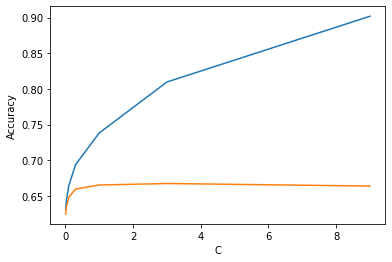

In [ ]:
parameters = {'C': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 9.0]}
log_reg = LogisticRegression(max_iter=1000)         # Creating an instance of Scikit Learn LogisticRegression class
grid_search = tune_parameters(log_reg, bag_of_words_norm, y_train, parameters, verbose=True)

In [ ]:
log_reg_best = grid_search.best_estimator_
evaluate_model(log_reg_best, bag_of_words_norm, bag_of_words_test_norm, y_train, y_test)

Training accuracy: 0.8032222222222222
Testing accuracy: 0.679
Precision on test data: 0.6845360824742268
Recall on test data: 0.664
f1 score on test data: 0.6741116751269036


### 4.2 SVM with Linear Kernel

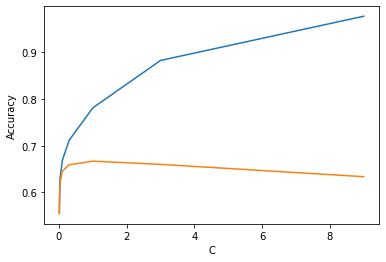

In [ ]:
parameters = {'C': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 9.0]}
svm = LinearSVC(C=10, loss='hinge', max_iter=10000)
grid_search = tune_parameters(svm, bag_of_words_norm, y_train, parameters, verbose=True)

In [ ]:
svm_best = grid_search.best_estimator_
evaluate_model(svm_best, bag_of_words_norm, bag_of_words_test_norm, y_train, y_test)

Training accuracy: 0.7765555555555556
Testing accuracy: 0.676
Precision on test data: 0.6739130434782609
Recall on test data: 0.682
f1 score on test data: 0.6779324055666004


### 4.3 SVM with Polynomial Kernel (degree=2)

In [ ]:
parameters = {'C': [0.01, 0.1, 1.0], 'coef0' : [1, 3, 10]}
svm = SVC(kernel='poly', degree=2)
grid_search = tune_parameters(svm, bag_of_words_norm, y_train, parameters, cv=ss)

In [ ]:
svm_best = grid_search.best_estimator_
evaluate_model(svm_best, bag_of_words_norm, bag_of_words_test_norm, y_train, y_test)

Training accuracy: 0.7186666666666667
Testing accuracy: 0.669
Precision on test data: 0.6720977596741344
Recall on test data: 0.66
f1 score on test data: 0.6659939455095863


In [ ]:
grid_search.best_params_

{'C': 0.1, 'coef0': 1}

In [ ]:
results = pd.DataFrame(grid_search.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_coef0,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,209.145704,0.0,49.903195,0.0,0.01,1,"{'C': 0.01, 'coef0': 1}",0.625556,0.625556,0.0,8,0.636667,0.636667,0.0
1,202.244189,0.0,47.471354,0.0,0.01,3,"{'C': 0.01, 'coef0': 3}",0.641111,0.641111,0.0,6,0.658333,0.658333,0.0
2,195.002509,0.0,46.139731,0.0,0.01,10,"{'C': 0.01, 'coef0': 10}",0.662222,0.662222,0.0,2,0.695278,0.695278,0.0
3,194.505054,0.0,44.871896,0.0,0.1,1,"{'C': 0.1, 'coef0': 1}",0.665556,0.665556,0.0,1,0.722361,0.722361,0.0
4,188.204734,0.0,44.122794,0.0,0.1,3,"{'C': 0.1, 'coef0': 3}",0.660556,0.660556,0.0,3,0.766250,0.766250,0.0


In [ ]:
filename = '4.3_GridSearchCV.sav'
pickle.dump(grid_search, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
results = pd.DataFrame(loaded_model.cv_results_)
results.head()

### 4.4 SVM with Gaussian Kernel

In [ ]:
parameters = {'C': [0.01, 0.1, 1.0, 10], 'gamma' : [1, 3, 10]}
svm = SVC(kernel="rbf")
grid_search = tune_parameters(svm, bag_of_words_norm, y_train, parameters, cv=ss)

In [ ]:
grid_search.best_params_

{'C': 10, 'gamma': 3}

In [ ]:
svm_best = grid_search.best_estimator_
evaluate_model(svm_best, bag_of_words_norm, bag_of_words_test_norm, y_train, y_test)

Training accuracy: 1.0
Testing accuracy: 0.664
Precision on test data: 0.6814159292035398
Recall on test data: 0.616
f1 score on test data: 0.6470588235294117


In [ ]:
results = pd.DataFrame(grid_search.cv_results_)
results.head()

In [ ]:
filename = '3.4_GridSearchCV.sav'
pickle.dump(grid_search, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
results = pd.DataFrame(loaded_model.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,222.924196,0.0,56.342695,0.0,0.01,1,"{'C': 0.01, 'gamma': 1}",0.611667,0.611667,0.0,9,0.605833,0.605833,0.0
1,222.763821,0.0,56.157765,0.0,0.01,3,"{'C': 0.01, 'gamma': 3}",0.593889,0.593889,0.0,10,0.602917,0.602917,0.0
2,224.383957,0.0,56.511477,0.0,0.01,10,"{'C': 0.01, 'gamma': 10}",0.491667,0.491667,0.0,11,0.502083,0.502083,0.0
3,206.588322,0.0,48.552021,0.0,0.1,1,"{'C': 0.1, 'gamma': 1}",0.646667,0.646667,0.0,4,0.670000,0.670000,0.0
4,212.547512,0.0,49.967282,0.0,0.1,3,"{'C': 0.1, 'gamma': 3}",0.635000,0.635000,0.0,6,0.665139,0.665139,0.0


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,222.924196,0.0,56.342695,0.0,0.01,1,"{'C': 0.01, 'gamma': 1}",0.611667,0.611667,0.0,9,0.605833,0.605833,0.0
1,222.763821,0.0,56.157765,0.0,0.01,3,"{'C': 0.01, 'gamma': 3}",0.593889,0.593889,0.0,10,0.602917,0.602917,0.0
2,224.383957,0.0,56.511477,0.0,0.01,10,"{'C': 0.01, 'gamma': 10}",0.491667,0.491667,0.0,11,0.502083,0.502083,0.0
3,206.588322,0.0,48.552021,0.0,0.1,1,"{'C': 0.1, 'gamma': 1}",0.646667,0.646667,0.0,4,0.670000,0.670000,0.0
4,212.547512,0.0,49.967282,0.0,0.1,3,"{'C': 0.1, 'gamma': 3}",0.635000,0.635000,0.0,6,0.665139,0.665139,0.0


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,222.924196,0.0,56.342695,0.0,0.01,1,"{'C': 0.01, 'gamma': 1}",0.611667,0.611667,0.0,9,0.605833,0.605833,0.0
1,222.763821,0.0,56.157765,0.0,0.01,3,"{'C': 0.01, 'gamma': 3}",0.593889,0.593889,0.0,10,0.602917,0.602917,0.0
2,224.383957,0.0,56.511477,0.0,0.01,10,"{'C': 0.01, 'gamma': 10}",0.491667,0.491667,0.0,11,0.502083,0.502083,0.0
3,206.588322,0.0,48.552021,0.0,0.1,1,"{'C': 0.1, 'gamma': 1}",0.646667,0.646667,0.0,4,0.670000,0.670000,0.0
4,212.547512,0.0,49.967282,0.0,0.1,3,"{'C': 0.1, 'gamma': 3}",0.635000,0.635000,0.0,6,0.665139,0.665139,0.0


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,222.924196,0.0,56.342695,0.0,0.01,1,"{'C': 0.01, 'gamma': 1}",0.611667,0.611667,0.0,9,0.605833,0.605833,0.0
1,222.763821,0.0,56.157765,0.0,0.01,3,"{'C': 0.01, 'gamma': 3}",0.593889,0.593889,0.0,10,0.602917,0.602917,0.0
2,224.383957,0.0,56.511477,0.0,0.01,10,"{'C': 0.01, 'gamma': 10}",0.491667,0.491667,0.0,11,0.502083,0.502083,0.0
3,206.588322,0.0,48.552021,0.0,0.1,1,"{'C': 0.1, 'gamma': 1}",0.646667,0.646667,0.0,4,0.670000,0.670000,0.0
4,212.547512,0.0,49.967282,0.0,0.1,3,"{'C': 0.1, 'gamma': 3}",0.635000,0.635000,0.0,6,0.665139,0.665139,0.0


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,222.924196,0.0,56.342695,0.0,0.01,1,"{'C': 0.01, 'gamma': 1}",0.611667,0.611667,0.0,9,0.605833,0.605833,0.0
1,222.763821,0.0,56.157765,0.0,0.01,3,"{'C': 0.01, 'gamma': 3}",0.593889,0.593889,0.0,10,0.602917,0.602917,0.0
2,224.383957,0.0,56.511477,0.0,0.01,10,"{'C': 0.01, 'gamma': 10}",0.491667,0.491667,0.0,11,0.502083,0.502083,0.0
3,206.588322,0.0,48.552021,0.0,0.1,1,"{'C': 0.1, 'gamma': 1}",0.646667,0.646667,0.0,4,0.670000,0.670000,0.0
4,212.547512,0.0,49.967282,0.0,0.1,3,"{'C': 0.1, 'gamma': 3}",0.635000,0.635000,0.0,6,0.665139,0.665139,0.0


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,222.924196,0.0,56.342695,0.0,0.01,1,"{'C': 0.01, 'gamma': 1}",0.611667,0.611667,0.0,9,0.605833,0.605833,0.0
1,222.763821,0.0,56.157765,0.0,0.01,3,"{'C': 0.01, 'gamma': 3}",0.593889,0.593889,0.0,10,0.602917,0.602917,0.0
2,224.383957,0.0,56.511477,0.0,0.01,10,"{'C': 0.01, 'gamma': 10}",0.491667,0.491667,0.0,11,0.502083,0.502083,0.0
3,206.588322,0.0,48.552021,0.0,0.1,1,"{'C': 0.1, 'gamma': 1}",0.646667,0.646667,0.0,4,0.670000,0.670000,0.0
4,212.547512,0.0,49.967282,0.0,0.1,3,"{'C': 0.1, 'gamma': 3}",0.635000,0.635000,0.0,6,0.665139,0.665139,0.0


### Observations:
* Logistic Regression gives the highest accuracy.
* We can see that SVM with polynomial kernel (degree 2) and Gaussian Kernel give less accuracy. This maybe because the decision boundary in this case would be linear, rather higher degree polynomial.

## 5. With Stemming, with stopwords, words that appear <=10 times removed, with numbers removed

In [ ]:
def process_text(review):
    review = review.lower()           # convert to lowercase

    review = re.sub("[^a-zA-Z#]", " ", review)    # Replace numbers, characters with space

    regex = re.compile('(?u)\\b\\w\\w+\\b')       # Break each sentence on the basis of punctuations, white spaces
    stemmer = PorterStemmer()
    return " ".join([stemmer.stem(WordNetLemmatizer().lemmatize(token, pos='v')) for token in regex.findall(review)])

In [ ]:
df_reviews = pd.Series([process_text(review) for review in df_reviews])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_reviews, labels, test_size=0.1, random_state=21, stratify=labels)

In [ ]:
X_train.shape, X_test.shape, len(y_train), len(y_test)

((9000,), (1000,), 9000, 1000)

In [ ]:
bag_of_words_norm, vect = get_feature_vector(X_train, min_df=9)

Vocabulary size: 8313
Number of features: 8313
First 20 features:
['aaron', 'aback', 'abandon', 'abba', 'abbi', 'abduct', 'abe', 'abi', 'abid', 'abigail', 'abil', 'abl', 'abli', 'abnorm', 'aboard', 'abomin', 'abort', 'abound', 'about', 'abov']
Features 20010 to 20030:
[]
Every 2000th feature:
['aaron', 'disarm', 'kathryn', 'rememb', 'walk']


In [ ]:
bag_of_words_test = vect.transform(X_test)
bag_of_words_test_norm = normalize(bag_of_words_test, norm='l2')
bag_of_words_test_norm

<1000x8313 sparse matrix of type '<class 'numpy.float64'>'
	with 138841 stored elements in Compressed Sparse Row format>

### 5.1 Logistic Regression

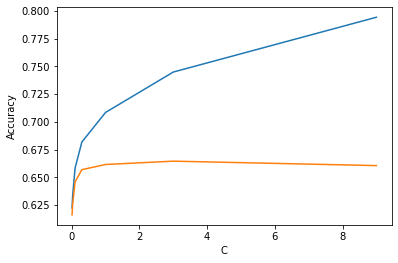

In [ ]:
parameters = {'C': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 9.0]}
log_reg = LogisticRegression(max_iter=1000)         # Creating an instance of Scikit Learn LogisticRegression class
grid_search = tune_parameters(log_reg, bag_of_words_norm, y_train, parameters, verbose=True)

In [ ]:
log_reg_best = grid_search.best_estimator_
evaluate_model(log_reg_best, bag_of_words_norm, bag_of_words_test_norm, y_train, y_test)

Training accuracy: 0.7415555555555555
Testing accuracy: 0.678
Precision on test data: 0.6808943089430894
Recall on test data: 0.67
f1 score on test data: 0.6754032258064516


### 5.2 SVM with Linear Kernel

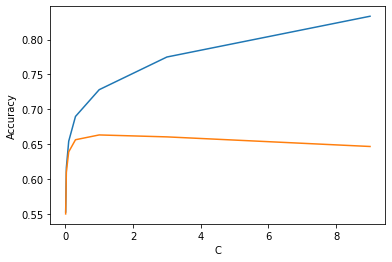

In [ ]:
parameters = {'C': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 9.0]}
svm = LinearSVC(C=10, loss='hinge', max_iter=10000)
grid_search = tune_parameters(svm, bag_of_words_norm, y_train, parameters, verbose=True)

In [ ]:
svm_best = grid_search.best_estimator_
evaluate_model(svm_best, bag_of_words_norm, bag_of_words_test_norm, y_train, y_test)

Training accuracy: 0.7244444444444444
Testing accuracy: 0.688
Precision on test data: 0.6865079365079365
Recall on test data: 0.692
f1 score on test data: 0.6892430278884462


### 5.3 SVM polynomial kernel (degree 2)

In [ ]:
parameters = {'C': [0.01, 0.1, 1.0], 'coef0' : [1, 5, 10]}
svm = SVC(kernel='poly', degree=2)
grid_search = tune_parameters(svm, bag_of_words_norm, y_train, parameters, cv=ss)

In [ ]:
svm_best = grid_search.best_estimator_
evaluate_model(svm_best, bag_of_words_norm, bag_of_words_test_norm, y_train, y_test)

Training accuracy: 0.7333333333333333
Testing accuracy: 0.684
Precision on test data: 0.6854838709677419
Recall on test data: 0.68
f1 score on test data: 0.6827309236947792


In [ ]:
results = pd.DataFrame(grid_search.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_coef0,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,106.098046,0.0,25.524196,0.0,0.01,1,"{'C': 0.01, 'coef0': 1}",0.623333,0.623333,0.0,9,0.625139,0.625139,0.0
1,100.495150,0.0,24.015777,0.0,0.01,5,"{'C': 0.01, 'coef0': 5}",0.650000,0.650000,0.0,6,0.660417,0.660417,0.0
2,99.257634,0.0,23.093102,0.0,0.01,10,"{'C': 0.01, 'coef0': 10}",0.655000,0.655000,0.0,4,0.680556,0.680556,0.0
3,98.286121,0.0,22.621397,0.0,0.1,1,"{'C': 0.1, 'coef0': 1}",0.664444,0.664444,0.0,2,0.700417,0.700417,0.0
4,94.063395,0.0,22.038396,0.0,0.1,5,"{'C': 0.1, 'coef0': 5}",0.666111,0.666111,0.0,1,0.735972,0.735972,0.0


In [ ]:
grid_search.best_params_

{'C': 0.1, 'coef0': 5}

In [ ]:
filename = '5.3_GridSearchCV.sav'
pickle.dump(grid_search, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
results = pd.DataFrame(loaded_model.cv_results_)
results.head()

### 5.4 SVM with Gaussian Kernel

In [ ]:
parameters = {'C': [0.01, 0.1, 1.0, 10], 'gamma' : [1, 3, 10]}
svm = SVC(kernel="rbf")
grid_search = tune_parameters(svm, bag_of_words_norm, y_train, parameters, cv=ss)

In [ ]:
grid_search.best_params_

{'C': 1.0, 'gamma': 1}

In [ ]:
svm_best = grid_search.best_estimator_
evaluate_model(svm_best, bag_of_words_norm, bag_of_words_test_norm, y_train, y_test)

Training accuracy: 0.789
Testing accuracy: 0.683
Precision on test data: 0.6942675159235668
Recall on test data: 0.654
f1 score on test data: 0.6735324407826982


In [ ]:
results = pd.DataFrame(grid_search.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,113.881364,0.0,28.766776,0.0,0.01,1,"{'C': 0.01, 'gamma': 1}",0.604444,0.604444,0.0,10,0.597222,0.597222,0.0
1,113.540735,0.0,28.808183,0.0,0.01,3,"{'C': 0.01, 'gamma': 3}",0.617222,0.617222,0.0,9,0.615417,0.615417,0.0
2,113.815990,0.0,28.772476,0.0,0.01,10,"{'C': 0.01, 'gamma': 10}",0.491667,0.491667,0.0,12,0.502083,0.502083,0.0
3,105.008748,0.0,24.894506,0.0,0.1,1,"{'C': 0.1, 'gamma': 1}",0.639444,0.639444,0.0,6,0.665556,0.665556,0.0
4,106.489595,0.0,25.251650,0.0,0.1,3,"{'C': 0.1, 'gamma': 3}",0.644444,0.644444,0.0,4,0.677083,0.677083,0.0


In [ ]:
filename = '5.4_GridSearchCV.sav'
pickle.dump(grid_search, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
results = pd.DataFrame(loaded_model.cv_results_)
results.head()

### Observations:
* SVM with Linear Kernel has the highest accuracy.
* We can see that SVM with polynomial kernel (degree 2) and Gaussian Kernel give less accuracy. This maybe because the decision boundary in this case would be linear, rather higher degree polynomial.

## 6. With Bigrams, with stopwords, words that appear in <=5 documents removed with numbers removed

In [ ]:
df_reviews = df_reviews.str.replace("[^a-zA-Z#]", " ") # Removing numbers, characters with space

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_reviews, labels, test_size=0.1, random_state=21, stratify=labels)

In [ ]:
X_train.shape, X_test.shape, len(y_train), len(y_test)

((9000,), (1000,), 9000, 1000)

In [ ]:
bag_of_words_norm, vect = get_feature_vector(X_train, ngram_range=(1,2), min_df=5)

Vocabulary size: 77992
Number of features: 77992
First 20 features:
['aamir', 'aang', 'aaron', 'aaron eckhart', 'aaron sorkin', 'aaron stanford', 'aaron taylor', 'aback', 'abandon', 'abandoned', 'abandoned by', 'abandonment', 'abandons', 'abba', 'abbey', 'abbie', 'abbie cornish', 'abducted', 'abducted by', 'abduction']
Features 20010 to 20030:
['enjoy them', 'enjoy themselves', 'enjoy this', 'enjoy watching', 'enjoy what', 'enjoy yourself', 'enjoyable', 'enjoyable action', 'enjoyable and', 'enjoyable as', 'enjoyable but', 'enjoyable experience', 'enjoyable film', 'enjoyable for', 'enjoyable from', 'enjoyable if', 'enjoyable in', 'enjoyable it', 'enjoyable movie', 'enjoyable the']
Every 2000th feature:
['aamir', 'already seen', 'and leo', 'are seeing', 'be among', 'bombs and', 'candle', 'come along', 'daredevil and', 'do believe', 'enjoy if', 'far as', 'for generations', 'go get', 'has what', 'his looks', 'in length', 'is really', 'just imagine', 'like lot', 'mason', 'most significant',

In [ ]:
bag_of_words_test = vect.transform(X_test)
bag_of_words_test_norm = normalize(bag_of_words_test, norm='l2')
bag_of_words_test_norm

<1000x77992 sparse matrix of type '<class 'numpy.float64'>'
	with 296941 stored elements in Compressed Sparse Row format>

### 6.1 Logistic Regression

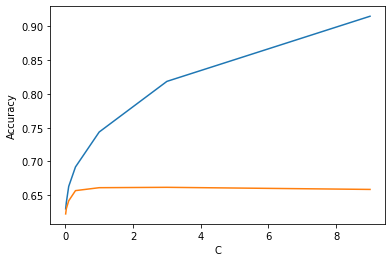

In [ ]:
parameters = {'C': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 9.0]}
log_reg = LogisticRegression(max_iter=1000)         # Creating an instance of Scikit Learn LogisticRegression class
grid_search = tune_parameters(log_reg, bag_of_words_norm, y_train, parameters, verbose=True)

In [ ]:
log_reg_best = grid_search.best_estimator_
evaluate_model(log_reg_best, bag_of_words_norm, bag_of_words_test_norm, y_train, y_test)

Training accuracy: 0.8134444444444444
Testing accuracy: 0.671
Precision on test data: 0.6777546777546778
Recall on test data: 0.652
f1 score on test data: 0.6646279306829765


### 6.2 SVM with Linear Kernel

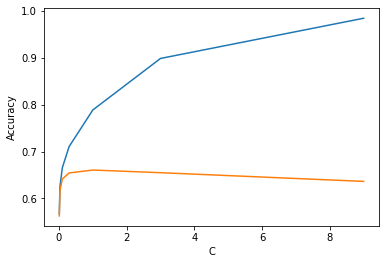

In [ ]:
parameters = {'C': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 9.0]}
svm = LinearSVC(C=10, loss='hinge', max_iter=10000)
grid_search = tune_parameters(svm, bag_of_words_norm, y_train, parameters, verbose=True)

In [ ]:
svm_best = grid_search.best_estimator_
evaluate_model(svm_best, bag_of_words_norm, bag_of_words_test_norm, y_train, y_test)

Training accuracy: 0.7845555555555556
Testing accuracy: 0.686
Precision on test data: 0.6875
Recall on test data: 0.682
f1 score on test data: 0.6847389558232932


## 7. With Bigram, with stemming, with stopwords, with words that appear in <=5 documents removed, with numbers removed

In [ ]:
def process_text(review):
    review = review.lower()           # convert to lowercase

    review = re.sub("[^a-zA-Z#]", " ", review)    # Replace numbers, characters with space

    regex = re.compile('(?u)\\b\\w\\w+\\b')       # Break each sentence on the basis of punctuations, white spaces
    stemmer = PorterStemmer()
    return " ".join([stemmer.stem(WordNetLemmatizer().lemmatize(token, pos='v')) for token in regex.findall(review)])

In [ ]:
df_reviews = pd.Series([process_text(review) for review in df_reviews])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_reviews, labels, test_size=0.1, random_state=21, stratify=labels)

In [ ]:
X_train.shape, X_test.shape, len(y_train), len(y_test)

((9000,), (1000,), 9000, 1000)

In [ ]:
bag_of_words_norm, vect = get_feature_vector(X_train, min_df=5, ngram_range=(1,2))

Vocabulary size: 71812
Number of features: 71812
First 20 features:
['aamir', 'aang', 'aaron', 'aaron eckhart', 'aaron johnson', 'aaron sorkin', 'aaron stanford', 'aaron taylor', 'ab', 'aback', 'abandon', 'abandon by', 'abandon the', 'abba', 'abbey', 'abbi', 'abbi cornish', 'abduct', 'abduct and', 'abduct by']
Features 20010 to 20030:
['event horizon', 'event in', 'event it', 'event lead', 'event occur', 'event of', 'event so', 'event take', 'event that', 'event the', 'event to', 'event unfold', 'event which', 'event would', 'eventu', 'eventu be', 'eventu becom', 'eventu come', 'eventu discov', 'eventu do']
Every 2000th feature:
['aamir', 'also so', 'and portray', 'ashor', 'be kind', 'bite over', 'can creat', 'colour be', 'dc cinemat', 'don understand', 'event', 'film how', 'fun', 'gush', 'heroic and', 'imagin him', 'it disturb', 'know you', 'love film', 'mind which', 'myself wonder', 'of class', 'one side', 'peopl into', 'properli', 'rest', 'see beauti', 'snippet', 'stori or', 'that c

In [ ]:
bag_of_words_test = vect.transform(X_test)
bag_of_words_test_norm = normalize(bag_of_words_test, norm='l2')
bag_of_words_test_norm

<1000x71812 sparse matrix of type '<class 'numpy.float64'>'
	with 302120 stored elements in Compressed Sparse Row format>

### 7.1 Logistic Regression

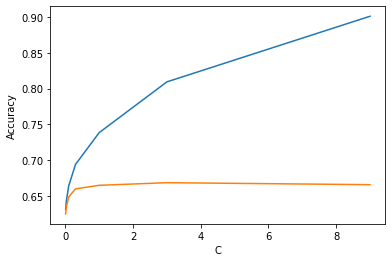

In [ ]:
parameters = {'C': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 9.0]}
log_reg = LogisticRegression(max_iter=1000)         # Creating an instance of Scikit Learn LogisticRegression class
grid_search = tune_parameters(log_reg, bag_of_words_norm, y_train, parameters, verbose=True)

In [ ]:
log_reg_best = grid_search.best_estimator_
evaluate_model(log_reg_best, bag_of_words_norm, bag_of_words_test_norm, y_train, y_test)

Training accuracy: 0.8043333333333333
Testing accuracy: 0.678
Precision on test data: 0.6838842975206612
Recall on test data: 0.662
f1 score on test data: 0.6727642276422764


### 7.2 SVM with Linear Kernel

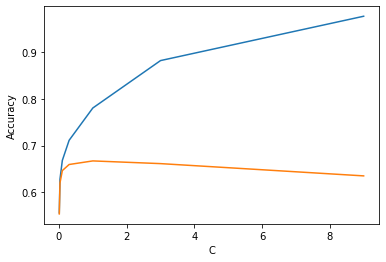

In [ ]:
parameters = {'C': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 9.0]}
svm = LinearSVC(C=10, loss='hinge', max_iter=10000)
grid_search = tune_parameters(svm, bag_of_words_norm, y_train, parameters, verbose=True)

In [ ]:
svm_best = grid_search.best_estimator_
evaluate_model(svm_best, bag_of_words_norm, bag_of_words_test_norm, y_train, y_test)

Training accuracy: 0.777
Testing accuracy: 0.676
Precision on test data: 0.6746031746031746
Recall on test data: 0.68
f1 score on test data: 0.6772908366533866


# Tf-Idf

In [ ]:
def get_feature_vector_tfidf(X, min_df=0, stop_words=False, ngram_range=(1,1), verbose = True, tokenizer=None, binary=False):
  vect_tfidf = TfidfVectorizer(min_df=min_df, stop_words = "english" if stop_words else None, ngram_range=ngram_range, tokenizer=tokenizer, binary=binary)
  vect_tfidf.fit(X)                                             # Create the vocabulary of words for the given reviews dataset

  print("Vocabulary size: {}".format(len(vect_tfidf.vocabulary_)))

  if verbose:
    feature_names = vect_tfidf.get_feature_names()
    print("Number of features: {}".format(len(feature_names)))
    print("First 20 features:\n{}".format(feature_names[:20]))
    print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
    print("Every 2000th feature:\n{}".format(feature_names[::2000]))

  tfidf_feature_norm = vect_tfidf.transform(X)               # Transform the reviews into feature vector
  # tfidf_feature_norm = normalize(tfidf_feature, norm='l2')  # Normalize the feature vectors obtained

  return tfidf_feature_norm, vect_tfidf

## 8. With Bigrams, with stopwords, words that appear in <=5 documents removed

In [ ]:
tfidf_feature_norm, vect_tfidf = get_feature_vector_tfidf(X_train, ngram_range=(1,2), min_df=5)

Vocabulary size: 78398
Number of features: 78398
First 20 features:
['00', '000', '000 000', '000 and', '000 year', '007', '02', '05', '07', '09', '10', '10 000', '10 10', '10 15', '10 all', '10 also', '10 and', '10 as', '10 at', '10 because']
Features 20010 to 20030:
['embassy', 'embedded', 'embellished', 'emblem', 'embodied', 'embodies', 'embodies the', 'embodiment', 'embodiment of', 'embrace', 'embrace the', 'embraced', 'embraces', 'embracing', 'embryos', 'emerge', 'emerge and', 'emerge from', 'emerged', 'emerged as']
Every 2000th feature:
['00', 'aliens are', 'and excellent', 'apparently the', 'backstory and', 'bigelow', 'by stephen', 'classic like', 'cringe worthy', 'director could', 'embark', 'fabric', 'five', 'get worse', 'hans zimmer', 'him anyway', 'importantly', 'is executed', 'job was', 'leper', 'male characters', 'monumental', 'nelson and', 'of gold', 'opinion is', 'perhaps just', 'protocol', 'reported', 'scope', 'simply enjoy', 'stark', 'takes up', 'the continuity', 'the s

In [ ]:
tfidf_feature_test_norm = vect_tfidf.transform(X_test)
tfidf_feature_test_norm

<1000x78398 sparse matrix of type '<class 'numpy.float64'>'
	with 297743 stored elements in Compressed Sparse Row format>

### 8.1 Logistic Regression

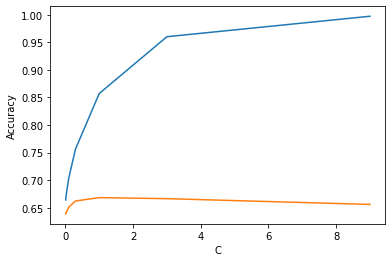

In [ ]:
parameters = {'C': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 9.0]}
log_reg = LogisticRegression(max_iter=1000)         # Creating an instance of Scikit Learn LogisticRegression class
grid_search = tune_parameters(log_reg, tfidf_feature_norm, y_train, parameters, verbose=True)

In [ ]:
log_reg_best = grid_search.best_estimator_
evaluate_model(log_reg_best, tfidf_feature_norm, tfidf_feature_test_norm, y_train, y_test)

Training accuracy: 0.8502222222222222
Testing accuracy: 0.674
Precision on test data: 0.6933333333333334
Recall on test data: 0.624
f1 score on test data: 0.6568421052631579


### 8.2 SVM with Linear Kernel

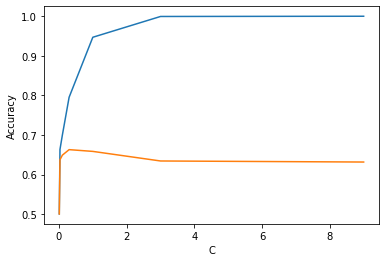

In [ ]:
parameters = {'C': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 9.0]}
svm = LinearSVC(C=10, loss='hinge', max_iter=10000)
grid_search = tune_parameters(svm, tfidf_feature_norm, y_train, parameters, verbose=True)

In [ ]:
svm_best = grid_search.best_estimator_
evaluate_model(svm_best, tfidf_feature_norm, tfidf_feature_test_norm, y_train, y_test)

Training accuracy: 0.7922222222222223
Testing accuracy: 0.68
Precision on test data: 0.7093023255813954
Recall on test data: 0.61
f1 score on test data: 0.6559139784946236


In [ ]:
grid_search.best_params_

{'C': 0.3}

In [ ]:
svm = LinearSVC(C=0.38125, loss='hinge', max_iter=10000)
svm.fit(tfidf_feature_norm, y_train)

LinearSVC(C=0.38125, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=10000, multi_class='ovr',
          penalty='l2', random_state=None, tol=0.0001, verbose=0)

In [ ]:
evaluate_model(svm, tfidf_feature_norm, tfidf_feature_test_norm, y_train, y_test)

Training accuracy: 0.8194444444444444
Testing accuracy: 0.684
Precision on test data: 0.7081447963800905
Recall on test data: 0.626
f1 score on test data: 0.664543524416136


### 8.3 SVM with Gaussian Kernel

In [ ]:
parameters = {'C': [0.01, 0.1, 1.0, 10], 'gamma' : [1, 3, 10]}
svm = SVC(kernel="rbf")
grid_search = tune_parameters(svm,  tfidf_feature_norm, y_train, parameters, cv=ss)

In [ ]:
grid_search.best_params_

{'C': 1.0, 'gamma': 1}

In [ ]:
svm = SVC(kernel='rbf', gamma=1, C=1)
svm.fit(tfidf_feature_norm, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
evaluate_model(svm, tfidf_feature_norm, tfidf_feature_test_norm, y_train, y_test)

Training accuracy: 0.984
Testing accuracy: 0.678
Precision on test data: 0.7004504504504504
Recall on test data: 0.622
f1 score on test data: 0.6588983050847457


Remove stopwords
Unigram
Stemming/Lemmatization
Numbers removed

In [ ]:
def process_text(review):
    review = review.lower()           # convert to lowercase

    review = re.sub("[^a-zA-Z#]", " ", review)    # Replace numbers, characters with space

    regex = re.compile('(?u)\\b\\w\\w+\\b')       # Break each sentence on the basis of punctuations, white spaces
    stemmer = PorterStemmer()
    return " ".join([stemmer.stem(WordNetLemmatizer().lemmatize(token, pos='v')) for token in regex.findall(review)])

In [ ]:
df_reviews = pd.Series([process_text(review) for review in df_reviews])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_reviews, labels, test_size=0.1, random_state=21, stratify=labels)

In [ ]:
X_train.shape, X_test.shape, len(y_train), len(y_test)

((9000,), (1000,), 9000, 1000)

In [ ]:
tfidf_feature_norm, vect_tfidf = get_feature_vector_tfidf(X_train, stop_words=True)

Vocabulary size: 30667
Number of features: 30667
First 20 features:
['aa', 'aaaaaaaaaaaaaagh', 'aaaahhhh', 'aaaalll', 'aaah', 'aaand', 'aachoo', 'aafv', 'aahhh', 'aal', 'aam', 'aamir', 'aang', 'aapn', 'aardvark', 'aaron', 'aaronofski', 'ab', 'aback', 'abacu']
Features 20010 to 20030:
['perenni', 'perez', 'perfect', 'perfecti', 'perfection', 'perfectionist', 'perfectli', 'perfectth', 'perfidi', 'perfom', 'perfor', 'perforc', 'perform', 'performac', 'performancesth', 'performancewhat', 'perfum', 'perfumeri', 'perfumi', 'perfunctori']
Every 2000th feature:
['aa', 'barbra', 'carnal', 'cruis', 'ecosystem', 'frasier', 'heavili', 'jigokumon', 'lunesta', 'myriad', 'perci', 'refigur', 'shakila', 'subconsci', 'tyranni', 'winni']


In [ ]:
tfidf_feature_test_norm = vect_tfidf.transform(X_test)
tfidf_feature_test_norm

<1000x30667 sparse matrix of type '<class 'numpy.float64'>'
	with 98197 stored elements in Compressed Sparse Row format>

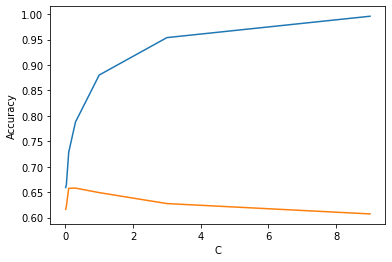

In [ ]:
parameters = {'C': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 9.0]}
svm = LinearSVC(C=10, loss='hinge', max_iter=10000)
grid_search = tune_parameters(svm, tfidf_feature_norm, y_train, parameters, verbose=True)

In [ ]:
svm_best = grid_search.best_estimator_
evaluate_model(svm_best, tfidf_feature_norm, tfidf_feature_test_norm, y_train, y_test)

Training accuracy: 0.781
Testing accuracy: 0.667
Precision on test data: 0.681917211328976
Recall on test data: 0.626
f1 score on test data: 0.6527632950990616


In [ ]:
svm = SVC(kernel="linear", gamma='auto', C=1)
svm.fit(tfidf_feature_norm, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
evaluate_model(svm, tfidf_feature_norm, tfidf_feature_test_norm, y_train, y_test)

Training accuracy: 0.865
Testing accuracy: 0.661
Precision on test data: 0.6680584551148225
Recall on test data: 0.64
f1 score on test data: 0.6537282941777324


# Rough

In [ ]:
def process_text(review):
    review = review.lower()           # convert to lowercase

    review = re.sub("[^a-zA-Z#]", " ", review)    # Replace numbers, characters with space

    regex = re.compile('(?u)\\b\\w\\w+\\b')       # Break each sentence on the basis of punctuations, white spaces
    stemmer = PorterStemmer()
    return " ".join([stemmer.stem(WordNetLemmatizer().lemmatize(token, pos='v')) for token in regex.findall(review)])

In [ ]:
df_reviews = pd.Series([process_text(review) for review in df_reviews])

In [ ]:
df_reviews.reset_index(drop=True, inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_reviews, labels, test_size=0.1, random_state=21, stratify=labels)

In [ ]:
X_train.index

Int64Index([1276, 9284, 5946, 1395, 6367, 4582, 6695, 6030, 9444, 8193,
            ...
            5684, 4476, 8264, 7860,  431, 4973, 3832, 4113, 4723, 8882],
           dtype='int64', length=9000)

In [ ]:
X_train_in = X_train.reset_index(drop=True)

In [ ]:
reviews = pd.DataFrame({'review_text': X_train_in, 'labels': y_train})

In [ ]:
reviews

,review_text,labels
0,possibl spoilersth whole movi be great until a...,1
1,let me start by say thi that have be one of th...,0
2,just don know be energ by all the hype for thi...,0
3,dare to say thi be the worst movi ve ever see ...,1
4,the th wave be american scienc fiction thrille...,0
...,...,...
8995,those that have not yet see room have not see ...,1
8996,the film have some great comed actor in it inc...,1
8997,from someon who have watch both film find thi ...,1
8998,tri not to be bia when stand in my local video...,1


In [ ]:
vect = CountVectorizer(stop_words="english", binary=True)
vect.fit(reviews[reviews['labels']==1]['review_text'])

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [ ]:
bag_of_words_spoiler = vect.transform(reviews[reviews['labels']==1]['review_text'])
freq_spoiler = bag_of_words_spoiler.sum(axis=0) 

In [ ]:
bag_of_words_spoiler

<4500x25017 sparse matrix of type '<class 'numpy.int64'>'
	with 540150 stored elements in Compressed Sparse Row format>

In [ ]:
freq_spoiler.shape

(1, 25017)

In [ ]:
freq_spoiler = np.ravel(freq_spoiler)

In [ ]:
freq_spoiler.shape

(25017,)

In [ ]:
freq_spoiler

array([2, 1, 1, ..., 1, 1, 1], dtype=int64)

In [ ]:
freq_spoiler.sum()

540150

In [ ]:
freq_spoiler_norm = freq_spoiler/np.linalg.norm(freq_spoiler)

In [ ]:
freq_spoiler_norm.sum()

32.41990911184031

In [ ]:
bag_of_words_non_spoiler = vect.transform(reviews[reviews['labels']==0]['review_text'])
freq_non_spoiler = bag_of_words_non_spoiler.sum(axis=0)

In [ ]:
bag_of_words_non_spoiler

<4500x25017 sparse matrix of type '<class 'numpy.int64'>'
	with 383643 stored elements in Compressed Sparse Row format>

In [ ]:
freq_non_spoiler.shape

(1, 25017)

In [ ]:
freq_non_spoiler = np.ravel(freq_non_spoiler)
freq_non_spoiler.shape

(25017,)

In [ ]:
freq_non_spoiler.sum()

383643

In [ ]:
freq_non_spoiler_norm = freq_non_spoiler/np.linalg.norm(freq_non_spoiler)

In [ ]:
freq_non_spoiler_norm.sum()

28.673400345670462

In [ ]:
freq_non_spoiler

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

In [ ]:
np.abs(freq_spoiler - freq_non_spoiler).max()

744

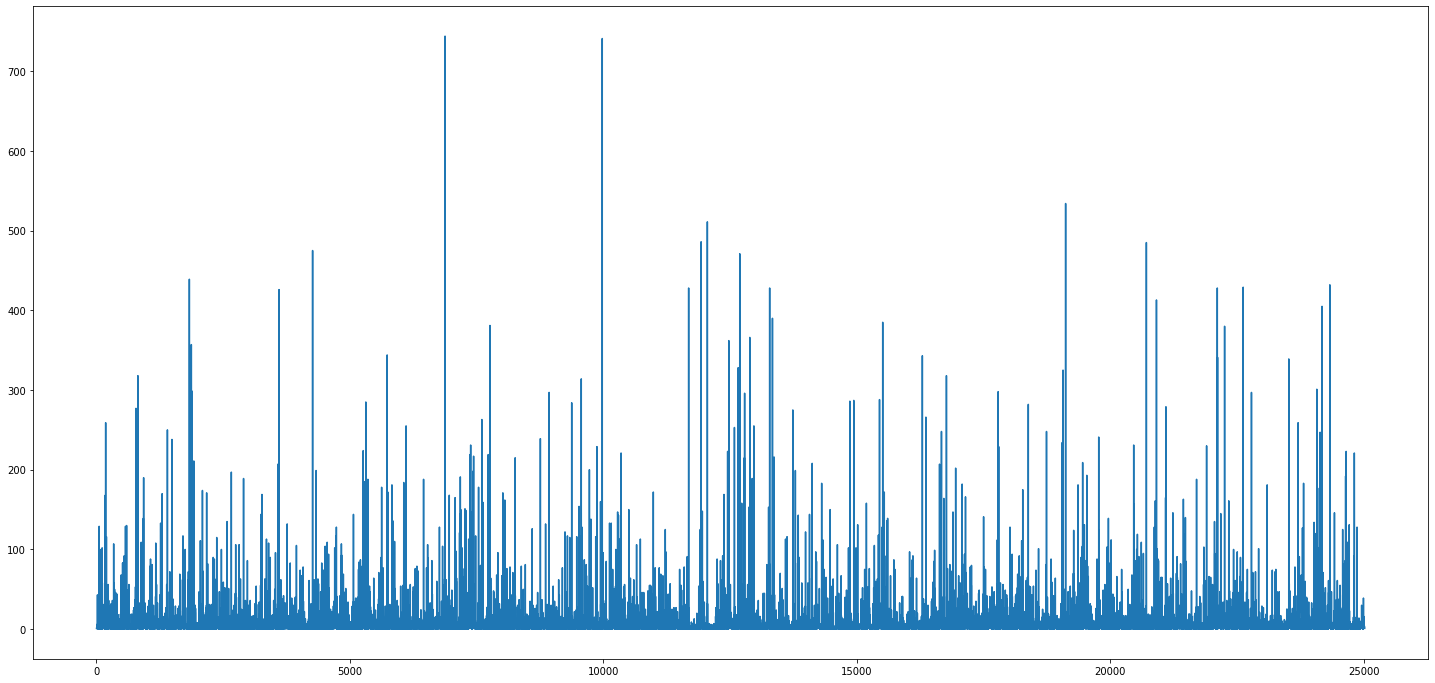

In [ ]:
plt.figure(figsize=(25,12))
plt.plot(np.abs(freq_spoiler - freq_non_spoiler))
plt.show()

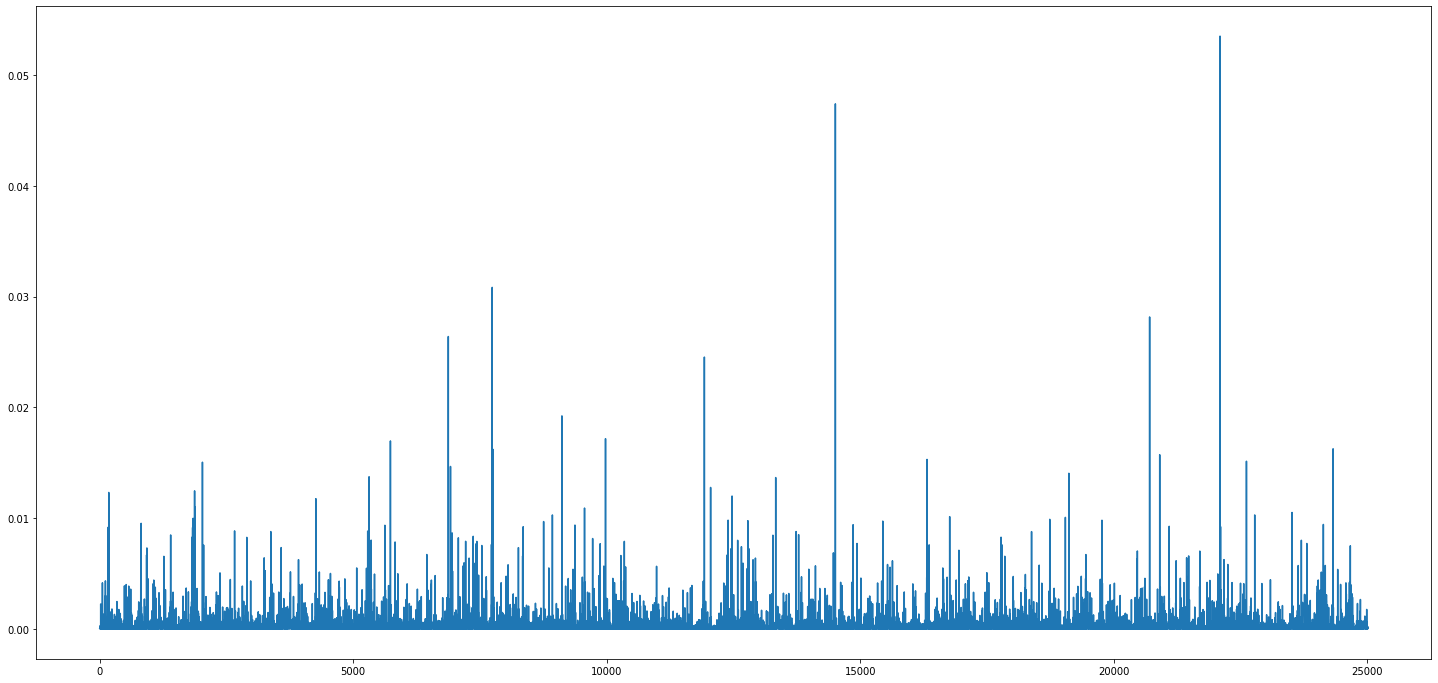

In [ ]:
plt.figure(figsize=(25,12))
plt.plot(np.abs(freq_spoiler_norm - freq_non_spoiler_norm))
plt.show()

In [ ]:
(np.abs(freq_spoiler - freq_non_spoiler) > 100).sum()

271

In [ ]:
np.where(np.abs(freq_spoiler - freq_non_spoiler) > 100)

(array([   53,   112,   167,   173,   181,   196,   339,   572,   594,
          779,   809,   817,   882,   924,   930,  1169,  1265,  1296,
         1399,  1488,  1706,  1832,  1842,  1871,  1878,  1920,  2049,
         2090,  2173,  2372,  2576,  2660,  2746,  2813,  2901,  3244,
         3264,  3353,  3395,  3579,  3601,  3762,  3944,  4263,  4332,
         4511,  4551,  4699,  4727,  4732,  4831,  5069,  5262,  5286,
         5313,  5354,  5625,  5732,  5734,  5747,  5828,  5844,  5880,
         6061,  6107,  6452,  6532,  6765,  6827,  6876,  6959,  7074,
         7162,  7168,  7177,  7186,  7211,  7269,  7286,  7342,  7367,
         7381,  7397,  7424,  7439,  7479,  7537,  7602,  7625,  7727,
         7742,  7762,  8016,  8055,  8259,  8595,  8756,  8859,  8929,
         9242,  9290,  9336,  9374,  9473,  9520,  9563,  9565,  9576,
         9723,  9753,  9848,  9872,  9943,  9977, 10121, 10154, 10279,
        10280, 10296, 10335, 10348, 10500, 10654, 10728, 10984, 11220,
      

In [ ]:
words_good = pd.Series(vect.get_feature_names()).iloc[np.abs(freq_spoiler_norm - freq_non_spoiler_norm) > 0.01]

In [ ]:
words_good

178        actor
1871       befor
1878       begin
2026        best
4263        come
5313       death
5734         die
6876         end
6919       enjoy
7742        film
7762       final
8929        good
9117       great
9563      happen
9977          hi
11927       kill
12050       know
12473       leav
13334        man
14511       movi
16319    perform
16766      point
19048       save
19117      scene
20710    spoiler
20909      start
22099        thi
22620        tri
22783       turn
23519        use
24329        whi
dtype: object

In [ ]:
words = pd.Series(vect.get_feature_names()).iloc[np.abs(freq_spoiler - freq_non_spoiler) > 100]

In [ ]:
vocabulary = {key : value for value, key in enumerate(words)}

In [ ]:
vocabulary_good = {key : value for value, key in enumerate(words_good)}

In [ ]:
vocabulary_good['turn'], vocabulary_good['end']

(28, 7)

In [ ]:
vect_1 = CountVectorizer(vocabulary=vocabulary_good)
vect_1.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None,
                vocabulary={'actor': 0, 'befor': 1, 'begin': 2, 'best': 3,
                            'come': 4, 'death': 5, 'die': 6, 'end': 7,
                            'enjoy': 8, 'film': 9, 'final': 10, 'good': 11,
                            'great': 12, 'happen': 13, 'hi': 14, 'kill': 15,
                            'know': 16, 'leav': 17, 'man': 18, 'movi': 19,
                            'perform': 20, 'point': 21, 'save': 22, 'scene': 23,
                            'spoiler': 24, 'start': 25, 'thi': 26, 'tri': 27,
                            'turn': 28, 'use': 29, ...})

In [ ]:
bag_of_words = vect_1.transform(X_train)
bag_of_words

<9000x31 sparse matrix of type '<class 'numpy.int64'>'
	with 74719 stored elements in Compressed Sparse Row format>

In [ ]:
bag_of_words_norm = normalize(bag_of_words)
bag_of_words_norm

<9000x31 sparse matrix of type '<class 'numpy.float64'>'
	with 74719 stored elements in Compressed Sparse Row format>

In [ ]:
bag_of_words_norm_dense = bag_of_words.todense()

In [ ]:
bag_of_words_norm_dense.shape

(9000, 31)

In [ ]:
bag_of_words_norm_dense[:, 24].shape

(9000, 1)

In [ ]:
bag_of_words_test = vect_1.transform(X_test)
bag_of_words_test

<1000x31 sparse matrix of type '<class 'numpy.int64'>'
	with 8162 stored elements in Compressed Sparse Row format>

In [ ]:
bag_of_words_test_norm = normalize(bag_of_words_test)
bag_of_words_test_norm

<1000x31 sparse matrix of type '<class 'numpy.float64'>'
	with 8162 stored elements in Compressed Sparse Row format>

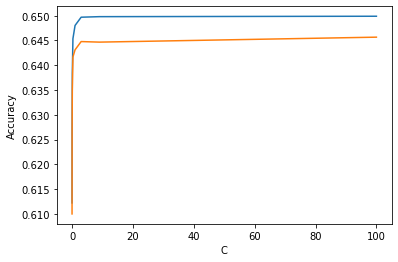

In [ ]:
parameters = {'C': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 9.0, 100]}
log_reg = LogisticRegression(max_iter=1000)         # Creating an instance of Scikit Learn LogisticRegression class
grid_search = tune_parameters(log_reg, bag_of_words_norm, y_train, parameters, verbose=True)

In [ ]:
log_reg_best = grid_search.best_estimator_
evaluate_model(log_reg_best, bag_of_words_norm, bag_of_words_test_norm, y_train, y_test)

Training accuracy: 0.6496666666666666
Testing accuracy: 0.65
Precision on test data: 0.676056338028169
Recall on test data: 0.576
f1 score on test data: 0.6220302375809934


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


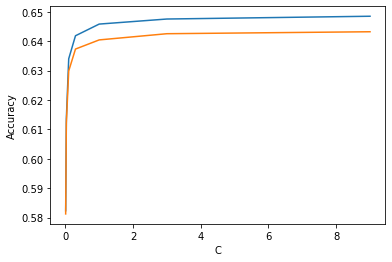

In [ ]:
parameters = {'C': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 9.0]}
svm = LinearSVC(C=10, loss='hinge', max_iter=10000)
grid_search = tune_parameters(svm, bag_of_words_norm, y_train, parameters, verbose=True)

In [ ]:
svm_best = grid_search.best_estimator_
evaluate_model(svm_best, bag_of_words_norm, bag_of_words_test_norm, y_train, y_test)

Training accuracy: 0.6465555555555556
Testing accuracy: 0.641
Precision on test data: 0.6766917293233082
Recall on test data: 0.54
f1 score on test data: 0.6006674082313681


In [ ]:
bag_of_words_norm

<9000x271 sparse matrix of type '<class 'numpy.float64'>'
	with 318757 stored elements in Compressed Sparse Row format>

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
svm = SVC(kernel="rbf", gamma=1, C=1)
svm.fit(bag_of_words_norm, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
evaluate_model(svm, bag_of_words_norm, bag_of_words_test_norm, y_train, y_test)

Training accuracy: 0.8395555555555556
Testing accuracy: 0.641
Precision on test data: 0.6584269662921348
Recall on test data: 0.586
f1 score on test data: 0.62010582010582


In [ ]:
(np.abs(freq_spoiler - freq_non_spoiler) > 200).sum()

88

In [ ]:
(np.abs(freq_spoiler - freq_non_spoiler) > 300).sum()

36